In [3]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun

%matplotlib inline

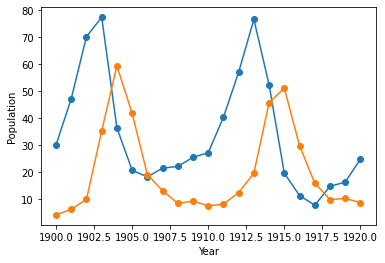

In [4]:
## Predator Prey Model

df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T

plt.figure()
plt.plot(year,hare,'-o')
plt.plot(year,lynx,'-o')
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()

In [5]:
# Parameter estimation
def predator_prey_sunode(t, y, p):
    du_dt = (p.alpha - p.beta * y.v) * y.u
    dv_dt = (-p.gamma + p.delta * y.u) * y.v
    return {'u': du_dt, 'v' : dv_dt}

In [9]:
# Split 1 n dimensional param into n 1 dimensional params
with model_sunode:
    def array_2_dict(param,length,prefix=''):
        d = dict()
        for i in range(length):
            d[prefix + str(i)] = param[i]
        return d

    def dict_2_array(d,length,prefix=''):
        return [d[prefix + str(i)] for i in range(length)]

    #xi = pm.Normal('xi', mu=1, sigma=0.5,shape=2)
    #print(dict_2_array(array_2_dict(xi,2,'xi'),2,prefix='xi'))

In [7]:
# Simple Parameter estimation of predator prey

model_sunode = pm.Model()

with model_sunode:
    
    sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2)
    alpha = pm.Normal('alpha', mu=1, sigma=0.5,shape=2)
    gamma = pm.Normal('gamma', mu=1, sigma=0.5)
    beta  = pm.Normal('beta', mu=0.05, sigma=0.05)
    delta = pm.Normal('delta', mu=0.05, sigma=0.05)
    y0    = pm.Lognormal('y0', mu=pm.math.log(10), sigma=1, shape=2)
    
    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'alpha': (alpha[0], ()),
                'beta':  (beta, ()),
                'gamma': (gamma, ()),
                'delta': (delta, ()),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode,
            tvals=times,
            t0=times[0],
        )[0]
    
    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs[:,1])

In [19]:
#with model_sunode:
#    trace = pm.sample(200, tune=100, cores=2, target_accept=0.9, init='adapt_diag')
#    pm.save_trace(trace,'my_trace.trace')

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y0, delta, beta, gamma, alpha, sigma]
Sampling 2 chains, 4 divergences: 100%|██████████| 600/600 [10:13<00:00,  1.02s/draws]
The acceptance probability does not match the target. It is 0.966004146404912, but should be close to 0.9. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9662526615355903, but should be close to 0.9. Try to increase the number of tuning steps.


/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/arviz/data/io_pymc3.py:218: UserWarning: Could not compute log_likelihood, it will be omitted.
                Check your model object or set log_likelihood=False
  Check your model object or set log_likelihood=False"""
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/arviz/data/io_pymc3.py:218: UserWarning: Could not compute log_likelihood, it will be omitted.
                Check your model object or set log_likelihood=False
  Check your model object or set log_likelihood=False"""


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.545,0.066,0.426,0.675,0.003,0.002,600.0,600.0,603.0,582.0,1.0
gamma,0.804,0.096,0.640,0.986,0.004,0.003,555.0,544.0,575.0,639.0,1.0
beta,0.028,0.004,0.019,0.035,0.000,0.000,630.0,621.0,636.0,799.0,1.0
delta,0.024,0.004,0.018,0.032,0.000,0.000,553.0,534.0,590.0,620.0,1.0
sigma[0],0.248,0.043,0.179,0.328,0.001,0.001,1338.0,1270.0,1412.0,1087.0,1.0
sigma[1],0.252,0.044,0.177,0.333,0.001,0.001,1447.0,1358.0,1598.0,1247.0,1.0
y0[0],34.122,2.938,28.619,39.318,0.075,0.054,1536.0,1474.0,1604.0,1393.0,1.0
y0[1],5.936,0.553,4.913,6.984,0.018,0.013,925.0,925.0,942.0,814.0,1.0


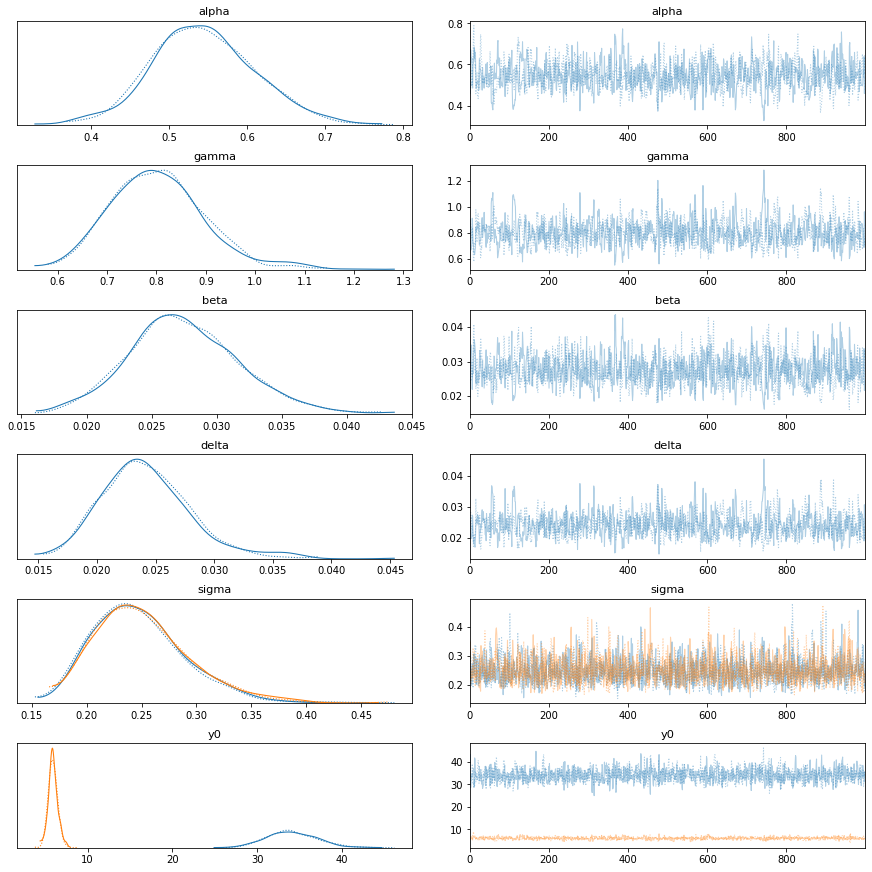

In [35]:
# run param_est.py to run model
trace = pm.backends.load_trace('param_est.trace',model=model_sunode)
pm.traceplot(trace);
pm.summary(trace)

In [9]:
def predator_prey_sunode_library(t, y, p):
    du_dt = p.p0 * y.u + p.pn0 * y.u * y.u + p.pn2 * y.u * y.v
    dv_dt = p.p1 * y.v + p.pn1 * y.v * y.v + p.pn3 * y.u * y.v
    return {'u': du_dt, 'v' : dv_dt}

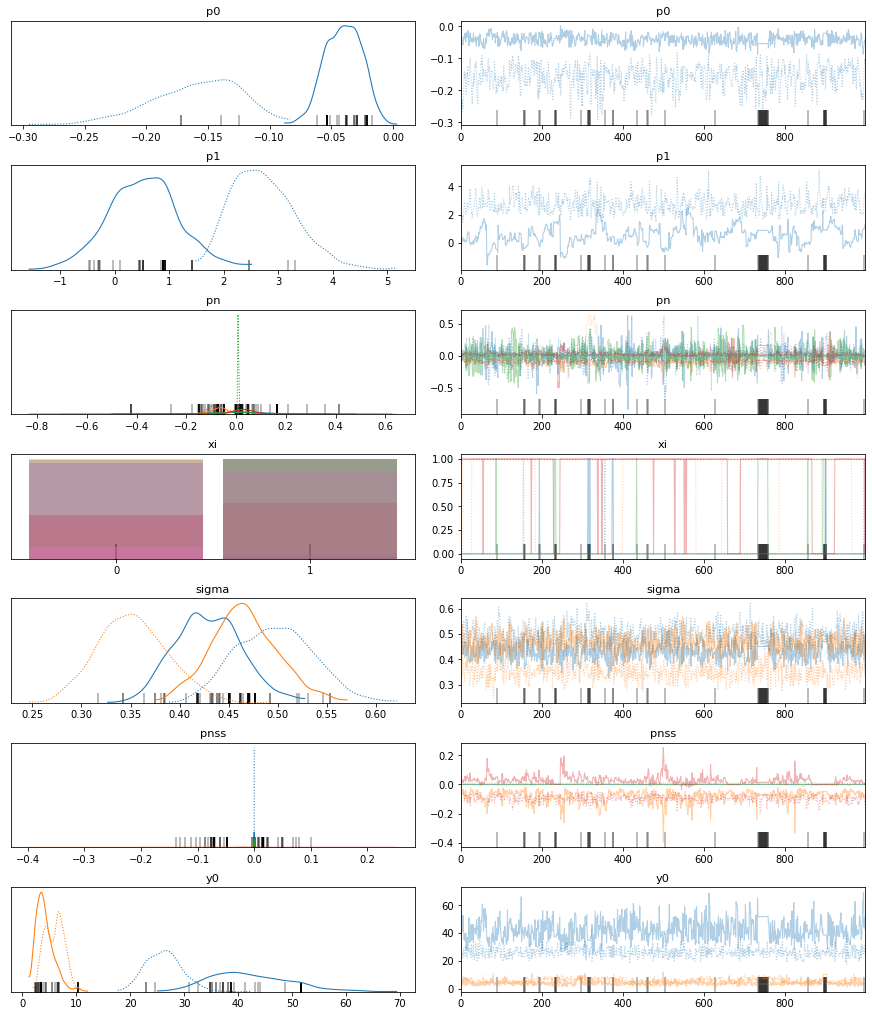

In [10]:
pm.traceplot(trace);

In [11]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p0,-0.100,0.066,-0.209,-0.012,0.043,0.035,2.0,2.0,3.0,110.0,1.83
p1,1.638,1.262,-0.420,3.768,0.791,0.640,3.0,3.0,3.0,148.0,1.82
pn[0],0.004,0.143,-0.286,0.283,0.003,0.005,1728.0,479.0,1765.0,963.0,1.00
pn[1],-0.034,0.097,-0.178,0.134,0.033,0.024,8.0,8.0,5.0,70.0,1.38
pn[2],0.006,0.103,-0.223,0.240,0.002,0.016,1947.0,20.0,1601.0,84.0,1.74
pn[3],-0.034,0.076,-0.150,0.071,0.044,0.035,3.0,3.0,4.0,191.0,1.60
xi[0],0.008,0.086,0.000,0.000,0.003,0.002,682.0,682.0,682.0,682.0,1.00
xi[1],0.779,0.415,0.000,1.000,0.134,0.098,10.0,10.0,10.0,10.0,1.24
xi[2],0.519,0.500,0.000,1.000,0.342,0.285,2.0,2.0,2.0,2.0,4.26
xi[3],0.942,0.235,1.000,1.000,0.031,0.022,56.0,56.0,56.0,56.0,1.08


In [8]:
g = pm.backends.load_trace('traces/ppsunodelibrary0.1.trace/',model=model_sunode)

NameError: name 'model_sunode' is not defined

In [10]:
# Adjusting σ
def display_trace(σ):
    print(σ)

    model_sunode = pm.Model()

    with model_sunode:

        #sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
        sigma = pm.Lognormal('sigma', mu=-1, sigma=σ, shape=2)
        p0 = pm.Normal('p0', mu=0, sigma=1.0)
        p1 = pm.Normal('p1', mu=0, sigma=1.0)

        # pn = pm.Normal('pn', mu=0, sigma=0.1, shape=4)
        pn = pm.Laplace('pn', mu=0, b=0.1, shape=4)

        # r  = pm.Beta('r', 1, 2)
        # xi = pm.Bernoulli('xi', r, shape=4)

        xi = pm.Bernoulli('xi', 0.8, shape=4)

        pnss = pm.Deterministic('pnss', pn * xi)

        y0 = pm.Lognormal('y0', mu=pm.math.log(10), sigma=1, shape=2)

        y_hat = sun.solve_ivp(
            y0={
                'u': (y0[0], ()),
                'v': (y0[1], ()),
                },
                params={
                    'p0': (p0, ()),
                    'p1': (p1, ()),
                    'pn0': (pnss[0], ()),
                    'pn1': (pnss[1], ()),
                    'pn2': (pnss[2], ()),
                    'pn3': (pnss[3], ()),
                    'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
                },
                rhs=predator_prey_sunode_library,
                tvals=times,
                t0=times[0],
            )[0]

        uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs[:,0])
        vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs[:,1])

    with model_sunode:
        trace = pm.backends.load_trace('traces/ppsunodelibrary' + 'sigma=' + str(σ) + '.trace',model=model_sunode)
        pm.traceplot(trace)
        pm.summary(trace)
    return trace

0.5


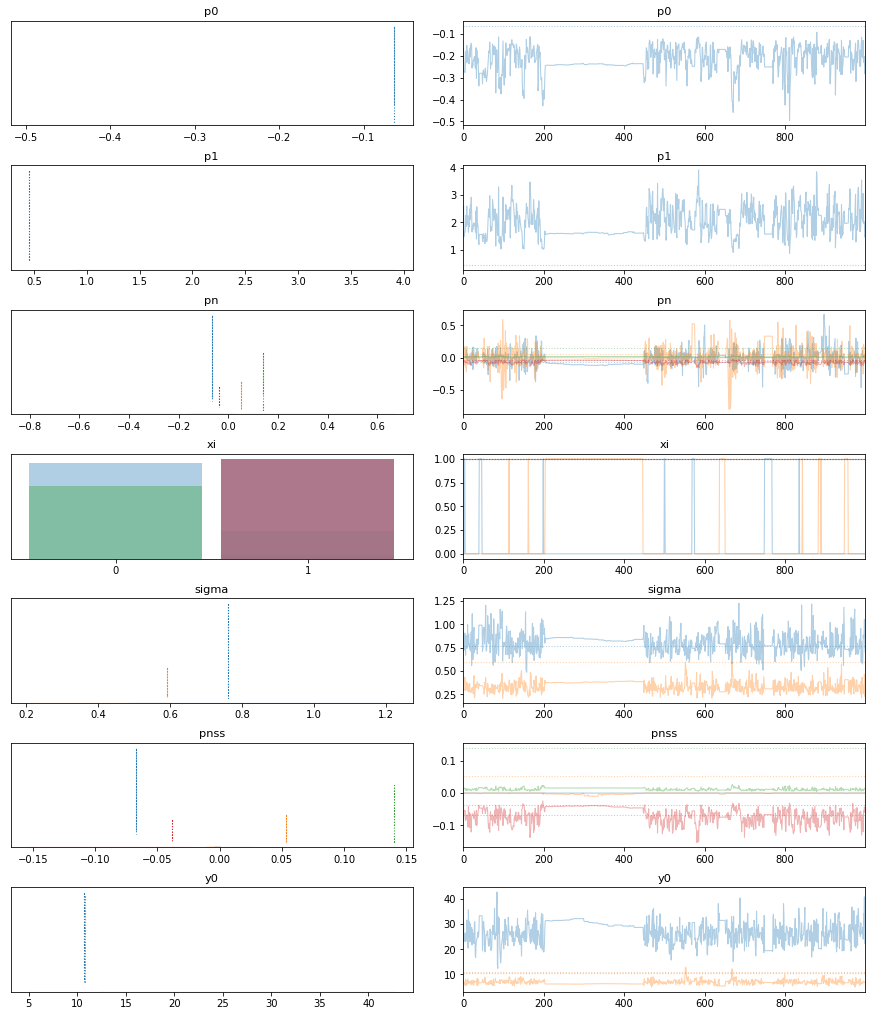

In [47]:
trace = display_trace(0.5)

In [45]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p0,-0.197,0.050,-0.289,-0.114,0.002,0.002,421.0,395.0,462.0,512.0,1.00
p1,2.279,0.505,1.351,3.181,0.023,0.017,462.0,462.0,443.0,476.0,1.00
pn[0],0.004,0.142,-0.272,0.294,0.004,0.004,1360.0,561.0,1525.0,719.0,1.00
pn[1],-0.004,0.002,-0.007,-0.001,0.000,0.000,748.0,608.0,913.0,552.0,1.01
pn[2],0.010,0.003,0.006,0.016,0.000,0.000,411.0,378.0,463.0,397.0,1.00
pn[3],-0.078,0.023,-0.124,-0.039,0.001,0.001,626.0,626.0,593.0,592.0,1.00
xi[0],0.031,0.173,0.000,0.000,0.012,0.008,226.0,226.0,226.0,226.0,1.00
xi[1],0.998,0.050,1.000,1.000,0.002,0.002,402.0,402.0,402.0,2000.0,1.00
xi[2],1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,2000.0,2000.0,NaN
xi[3],1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,2000.0,2000.0,NaN


In [48]:
# Hierarchial prior
def display_trace(σ,β):
    print(σ)

    model_sunode = pm.Model()

    with model_sunode:

        #sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
        sigma = pm.Lognormal('sigma', mu=-1, sigma=σ, shape=2)
        p0 = pm.Normal('p0', mu=0, sigma=1.0)
        p1 = pm.Normal('p1', mu=0, sigma=1.0)

        # pn = pm.Normal('pn', mu=0, sigma=0.1, shape=4)
        pn = pm.Laplace('pn', mu=0, b=0.1, shape=4)

        r  = pm.Beta('r', 1, β)
        xi = pm.Bernoulli('xi', r, shape=4)

        #xi = pm.Bernoulli('xi', 0.8, shape=4)

        pnss = pm.Deterministic('pnss', pn * xi)

        y0 = pm.Lognormal('y0', mu=pm.math.log(10), sigma=1, shape=2)

        y_hat = sun.solve_ivp(
            y0={
                'u': (y0[0], ()),
                'v': (y0[1], ()),
                },
                params={
                    'p0': (p0, ()),
                    'p1': (p1, ()),
                    'pn0': (pnss[0], ()),
                    'pn1': (pnss[1], ()),
                    'pn2': (pnss[2], ()),
                    'pn3': (pnss[3], ()),
                    'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
                },
                rhs=predator_prey_sunode_library,
                tvals=times,
                t0=times[0],
            )[0]

        uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs[:,0])
        vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs[:,1])

    with model_sunode:
        trace = pm.backends.load_trace('traces/ppsunodelibrary' + 'sigma=' + str(σ) + "beta=" + str(β) + '.trace',model=model_sunode)
        pm.traceplot(trace)
        pm.summary(trace)
    return trace

0.1


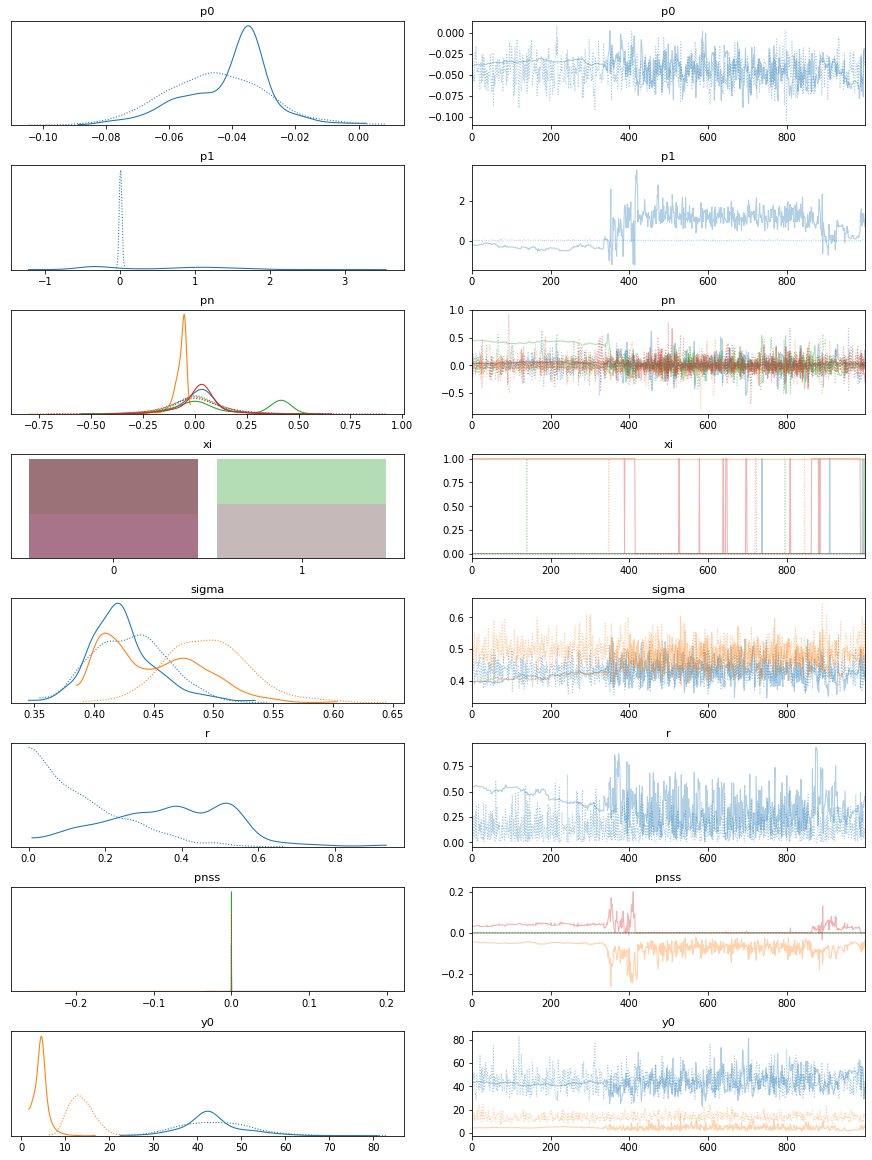

In [53]:
trace = display_trace(0.1,2)

In [50]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p0,0.254,0.305,-0.081,0.654,0.212,0.178,2.0,2.0,3.0,75.0,1.83
p1,-0.394,0.413,-0.940,0.056,0.286,0.240,2.0,2.0,3.0,103.0,1.83
pn[0],0.000,0.143,-0.277,0.287,0.004,0.004,1350.0,648.0,1655.0,860.0,1.00
pn[1],0.003,0.136,-0.263,0.292,0.003,0.004,1556.0,745.0,1795.0,996.0,1.00
pn[2],-0.012,0.100,-0.228,0.184,0.003,0.013,1448.0,28.0,602.0,89.0,1.63
pn[3],0.017,0.106,-0.188,0.253,0.003,0.014,1483.0,30.0,939.0,71.0,1.67
xi[0],0.001,0.032,0.000,0.000,0.001,0.000,2008.0,2008.0,2008.0,2008.0,1.00
xi[1],0.002,0.045,0.000,0.000,0.001,0.001,1339.0,1339.0,1339.0,1339.0,1.00
xi[2],0.501,0.500,0.000,1.000,0.352,0.297,2.0,2.0,2.0,2.0,18.27
xi[3],0.501,0.500,0.000,1.000,0.352,0.297,2.0,2.0,2.0,2.0,18.27
